## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

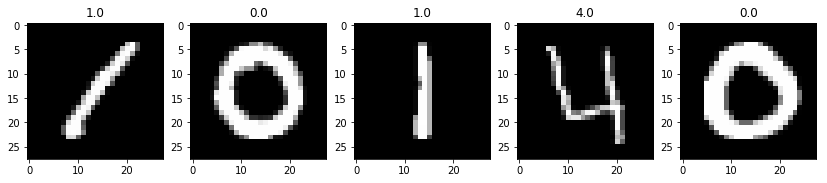

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

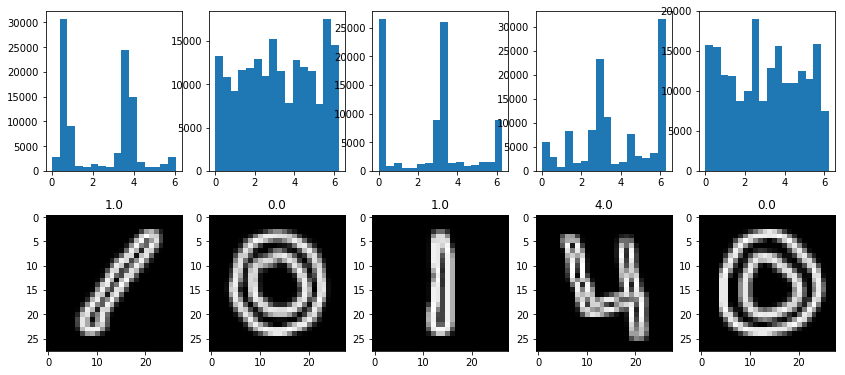

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [213]:
## делим изображение на 4 части и для стрроим гистограмму

In [97]:
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist1, borders1 = np.histogram(train_theta[i][15:,15:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][15:,15:])
    hist2, borders2 = np.histogram(train_theta[i][:15,15:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][:15,15:])
    hist3, borders3 = np.histogram(train_theta[i][15:,:15],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][15:,:15])
    hist4, borders4 = np.histogram(train_theta[i][:15,:15],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][:15,:15])
    train_hist[i] = np.concatenate( (hist1,hist2,hist3,hist4), axis=0)

In [98]:
# Гистограммы вычисляются с учетом длины вектора градиента
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist1, borders1 = np.histogram(test_theta[i][15:,15:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][15:,15:])
    hist2, borders2 = np.histogram(test_theta[i][:15,15:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][:15,15:])
    hist3, borders3 = np.histogram(test_theta[i][15:,:15],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][15:,:15])
    hist4, borders4 = np.histogram(test_theta[i][:15,:15],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][:15,:15])
    test_hist[i] = np.concatenate( (hist1,hist2,hist3,hist4), axis=0)

## Нормируем вектор гистограммы

In [99]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [100]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [101]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [102]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [103]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [104]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [105]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.825


In [106]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.90      0.92      0.91       816
        1.0       0.89      0.89      0.89       909
        2.0       0.87      0.82      0.84       846
        3.0       0.77      0.87      0.82       937
        4.0       0.86      0.77      0.82       839
        5.0       0.89      0.85      0.87       702
        6.0       0.87      0.91      0.89       785
        7.0       0.82      0.79      0.81       893
        8.0       0.67      0.79      0.72       835
        9.0       0.76      0.65      0.70       838

avg / total       0.83      0.82      0.82      8400



In [107]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[753   3   9   8  12   7   9   1  13   1]
 [  0 809   3   0   7   0   7  25  55   3]
 [  8   7 691  74   9   6   8  13  25   5]
 [  6   0  20 812   1  25   3   8  41  21]
 [  8  22   7   1 650   0  49   9  46  47]
 [  2   1   0  64   1 596   8   2  25   3]
 [ 21   9   0   1   9   3 712   0  30   0]
 [  3  27  36  18   5   1   2 709  26  66]
 [ 27  13  21  25  12  31  12  10 657  27]
 [ 12  19   3  46  49   3   6  90  69 541]]


## SVM

In [172]:
from sklearn.svm import SVC
svc = SVC().fit(x_train, y_train)

In [173]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, svc.predict(x_val)))

Accuracy: 0.917738095238


## CatBoost

In [226]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.1, loss_function='MultiClass', verbose=True)
model.fit(x_train, y_train, verbose=True)
preds_class = model.predict(x_val)


Borders for float features generated
0:	learn -2.007365558	total: 335ms	remaining: 2m 47s
1:	learn -1.811582986	total: 671ms	remaining: 2m 47s
2:	learn -1.664144943	total: 1.01s	remaining: 2m 46s
3:	learn -1.544644961	total: 1.34s	remaining: 2m 46s
4:	learn -1.44623304	total: 1.67s	remaining: 2m 44s
5:	learn -1.359089739	total: 2s	remaining: 2m 45s
6:	learn -1.281275619	total: 2.33s	remaining: 2m 44s
7:	learn -1.218367171	total: 2.66s	remaining: 2m 43s
8:	learn -1.153238919	total: 3.01s	remaining: 2m 44s
9:	learn -1.094012985	total: 3.35s	remaining: 2m 44s
10:	learn -1.040712936	total: 3.67s	remaining: 2m 43s
11:	learn -0.9930023717	total: 4.01s	remaining: 2m 42s
12:	learn -0.9512325861	total: 4.33s	remaining: 2m 42s
13:	learn -0.9114064829	total: 4.65s	remaining: 2m 41s
14:	learn -0.8762175904	total: 4.97s	remaining: 2m 40s
15:	learn -0.8397582575	total: 5.33s	remaining: 2m 41s
16:	learn -0.8048714237	total: 5.65s	remaining: 2m 40s
17:	learn -0.7754427714	total: 6s	remaining: 2m 40s
1

150:	learn -0.1430070709	total: 50.1s	remaining: 1m 55s
151:	learn -0.142439872	total: 50.4s	remaining: 1m 55s
152:	learn -0.1414214442	total: 50.7s	remaining: 1m 55s
153:	learn -0.1403977332	total: 51.1s	remaining: 1m 54s
154:	learn -0.1394719787	total: 51.5s	remaining: 1m 54s
155:	learn -0.1384368645	total: 51.8s	remaining: 1m 54s
156:	learn -0.1379828997	total: 52.1s	remaining: 1m 53s
157:	learn -0.1374182551	total: 52.5s	remaining: 1m 53s
158:	learn -0.1360745593	total: 52.8s	remaining: 1m 53s
159:	learn -0.1352722234	total: 53.1s	remaining: 1m 52s
160:	learn -0.1347342905	total: 53.4s	remaining: 1m 52s
161:	learn -0.1340975771	total: 53.8s	remaining: 1m 52s
162:	learn -0.1334985863	total: 54.1s	remaining: 1m 51s
163:	learn -0.1328230621	total: 54.5s	remaining: 1m 51s
164:	learn -0.132409085	total: 54.8s	remaining: 1m 51s
165:	learn -0.1317729703	total: 55.1s	remaining: 1m 50s
166:	learn -0.1312184577	total: 55.5s	remaining: 1m 50s
167:	learn -0.1308842612	total: 55.9s	remaining: 1

295:	learn -0.08194152457	total: 1m 38s	remaining: 1m 7s
296:	learn -0.0817484526	total: 1m 38s	remaining: 1m 7s
297:	learn -0.08139343516	total: 1m 38s	remaining: 1m 6s
298:	learn -0.08122484734	total: 1m 39s	remaining: 1m 6s
299:	learn -0.0810091737	total: 1m 39s	remaining: 1m 6s
300:	learn -0.080692343	total: 1m 39s	remaining: 1m 5s
301:	learn -0.08050402427	total: 1m 40s	remaining: 1m 5s
302:	learn -0.08028706974	total: 1m 40s	remaining: 1m 5s
303:	learn -0.08013664049	total: 1m 40s	remaining: 1m 4s
304:	learn -0.07990393127	total: 1m 41s	remaining: 1m 4s
305:	learn -0.07973821395	total: 1m 41s	remaining: 1m 4s
306:	learn -0.07920699071	total: 1m 41s	remaining: 1m 3s
307:	learn -0.0790293098	total: 1m 42s	remaining: 1m 3s
308:	learn -0.0786823947	total: 1m 42s	remaining: 1m 3s
309:	learn -0.07840118438	total: 1m 42s	remaining: 1m 2s
310:	learn -0.07818755097	total: 1m 43s	remaining: 1m 2s
311:	learn -0.07768798351	total: 1m 43s	remaining: 1m 2s
312:	learn -0.07755800154	total: 1m 4

441:	learn -0.0564335054	total: 2m 26s	remaining: 19.2s
442:	learn -0.05635331226	total: 2m 26s	remaining: 18.9s
443:	learn -0.05622900088	total: 2m 27s	remaining: 18.6s
444:	learn -0.05599571099	total: 2m 27s	remaining: 18.2s
445:	learn -0.05583721917	total: 2m 27s	remaining: 17.9s
446:	learn -0.05573854602	total: 2m 28s	remaining: 17.6s
447:	learn -0.05561535876	total: 2m 28s	remaining: 17.2s
448:	learn -0.05550476523	total: 2m 28s	remaining: 16.9s
449:	learn -0.05543220733	total: 2m 29s	remaining: 16.6s
450:	learn -0.05523836799	total: 2m 29s	remaining: 16.2s
451:	learn -0.05513616152	total: 2m 29s	remaining: 15.9s
452:	learn -0.05504650614	total: 2m 30s	remaining: 15.6s
453:	learn -0.054942665	total: 2m 30s	remaining: 15.2s
454:	learn -0.05485403281	total: 2m 30s	remaining: 14.9s
455:	learn -0.0547805365	total: 2m 31s	remaining: 14.6s
456:	learn -0.0545871161	total: 2m 31s	remaining: 14.2s
457:	learn -0.05449076712	total: 2m 31s	remaining: 13.9s
458:	learn -0.05435960364	total: 2m 

In [227]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, preds_class))

Accuracy: 0.972261904762


In [228]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds_class))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       816
        1.0       0.99      0.99      0.99       909
        2.0       0.98      0.97      0.98       846
        3.0       0.97      0.97      0.97       937
        4.0       0.97      0.95      0.96       839
        5.0       0.97      0.97      0.97       702
        6.0       0.97      0.98      0.97       785
        7.0       0.98      0.97      0.97       893
        8.0       0.96      0.97      0.96       835
        9.0       0.95      0.97      0.96       838

avg / total       0.97      0.97      0.97      8400



In [230]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, preds_class))

[[804   0   4   1   0   0   4   1   1   1]
 [  0 901   2   1   1   0   2   1   1   0]
 [  3   0 823   7   4   1   0   2   4   2]
 [  0   0   3 908   0   8   0   4  12   2]
 [  3   1   1   0 801   1   9   2   2  19]
 [  1   0   0   9   2 678   3   1   8   0]
 [  3   4   1   0   5   2 767   0   3   0]
 [  0   0   6   5   3   0   0 868   2   9]
 [  2   0   0   0   1   8   8   3 807   6]
 [  3   2   1   5   5   1   0   6   5 810]]


## Предсказания на тестовыйх данных

In [231]:
pred_test = np.uint8(model.predict(test_hist).flatten())

## Визуализируем предсказания

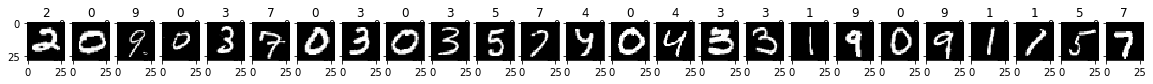

In [232]:
digits_to_show = 25
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:digits_to_show], 1):
    subplot = fig.add_subplot(1, digits_to_show, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [233]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [270]:
# Your submission scored 0.97042